# Assignment - Exercise 8.3 Neural Network CLassifiers
## Week#8&9
## Date - July-31-2021
## Author - Ganesh Kale

#### _import required packages_

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, sparse
from sklearn import datasets
import spacy
import sys
import unicodedata
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

%matplotlib inline


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#### _load the data set_

In [88]:
comments = pd.read_json("data/categorized-comments.jsonl",lines=True)

#### _display shape and head of dataset_

In [89]:
comments.shape
comments.head()

(606476, 2)

,cat,txt
0,sports,Barely better than Gabbert? He was significant...
1,sports,Fuck the ducks and the Angels! But welcome to ...
2,sports,Should have drafted more WRs.\n\n- Matt Millen...
3,sports,[Done](https://i.imgur.com/2YZ90pm.jpg)
4,sports,No!! NOO!!!!!


### This data set is having 600K records and after balancing classes it becomes over 1M and deep learning algorithms takes huge time to train on this data set, hence reducing size to 50K

In [98]:
cat_com = comments.sample(50000, random_state=101)

#### _display distribution of cat columns_

In [99]:
cat_com.cat.value_counts()

video_games               35665
sports                    12225
science_and_technology     2110
Name: cat, dtype: int64

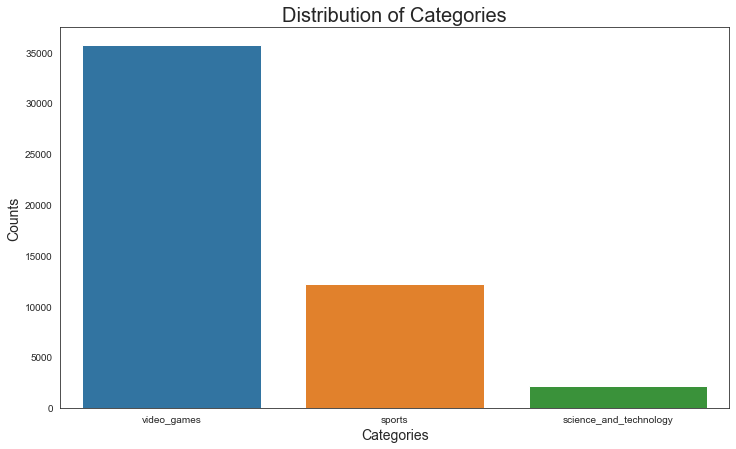

In [100]:
# display graphical distribution of cat columns


sns.set_style('white')
plt.figure(figsize=(12,7))

sns.barplot(x=cat_com.cat.value_counts().index, y=cat_com.cat.value_counts().values)
plt.xlabel("Categories",fontdict={"fontsize":14})
plt.ylabel("Counts",fontdict={"fontsize":14})
plt.title("Distribution of Categories",fontdict={"fontsize":20});

#### _Pre-Processing Text_

In [101]:
# lower case all text from txt column

cat_com['clean_text'] = cat_com['txt']

cat_com['clean_text'] = cat_com['clean_text'].apply(lambda x: x.lower())

In [102]:
#  create a function to clean textx

def clean_texts(strng):
    x = strng
    x = x.strip()  # remove white sapce
    # x = x.replace(' ',"")
    x = re.sub(r'\d',"",x)  # remove numbers
    x = re.sub(r"https\S+","",x)  # remove links
    x = ' '.join(w for w in x.split() if len(w)>2)  # remove words with len less than 2
    return x

In [103]:
# create new column for cleaned text

cat_com['clean_text'] = cat_com['clean_text'].apply(lambda x: clean_texts(x))

In [104]:
# remove punctuations and stop words from clean_text column

# dictionary of punctuations characters with keys and none as values

punctuations = dict.fromkeys(i for i in range(sys.maxunicode) if unicodedata.category(chr(i)).startswith('P'))

# removing punctuations from the text column
cat_com['clean_text'] = cat_com.clean_text.apply(lambda x : x.translate(punctuations))

In [105]:
# remove stop words using nltk 

stop_words = stopwords.words('english')

# removing stop words from the text column
cat_com['clean_text'] = cat_com.clean_text.apply(lambda x : ' '.join([word for word in word_tokenize(x) if word not in stop_words]))


In [106]:
# stemming the texts using nltk stemmer

from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()
cat_com['clean_text'] = cat_com.clean_text.apply(lambda x : ' '.join([porter.stem(word) for word in word_tokenize(x)]))

In [107]:
# keeping text length greater than 20 after cleaning text

cat_com['new'] = cat_com.clean_text.apply(lambda x: 'yes' if len(x) > 20 else 'no')

In [108]:
final = cat_com.loc[cat_com.loc[:,'new']=='yes']

In [109]:
# display head and tail of data sets

final.head()
final.tail()

,cat,txt,clean_text,new
337804,video_games,Makes me happy three bears are in there.,make happi three bear,yes
25541,science_and_technology,&gt;I don't think that many people feel handic...,gti dont think mani peopl feel handicap that c...,yes
180767,video_games,It wasnt meant against some particular heroes ...,wasnt meant particular hero gener carri could ...,yes
505628,video_games,Fair point. I didn't see where she was before...,fair point didnt see reze much could case,yes
130798,video_games,This special ammo change is pointless if you a...,special ammo chang pointless ask funni everi s...,yes


,cat,txt,clean_text,new
500141,video_games,I just don't like joysticks. I could have so m...,dont like joystick could much aim capabl m+kb ...,yes
261340,sports,Then whats the point of playing clubs?\n\nMe a...,what point play club mate never use like year ...,yes
560073,video_games,This is also a good tip. Unless that angry Jap...,also good tip unless angri japanes sound littl...,yes
26578,science_and_technology,Let's be mature and not bring people's dangles...,let matur bring peopl dangl talk cell phone,yes
124174,video_games,Well rumble is not just 1v1 it's ur awarness a...,well rumbl awar surviv skill take part posit u...,yes


In [110]:
# distribution of categories in final data set and main data set - cat_com

final.cat.value_counts()

cat_com.cat.value_counts()

video_games               26433
sports                     8525
science_and_technology     1645
Name: cat, dtype: int64

video_games               35665
sports                    12225
science_and_technology     2110
Name: cat, dtype: int64

## Balance the imbalanced classes

In [111]:
# import SMOTE

from imblearn.over_sampling import SMOTE

In [112]:
# create instance of SMOTE

smote = SMOTE()

In [113]:
# import TF-IDF vectorizer and create instance

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

In [114]:
# create features by using tfidf model on cleaned text column

X = tfidf.fit_transform(final['clean_text'])

In [115]:
# import lable encoder and endocde target class

from sklearn.preprocessing import LabelEncoder

one_hot = LabelEncoder()
y = one_hot.fit_transform(final['cat'])

In [116]:
# display the encoded values mapping with classes

class_mapping = dict(zip(one_hot.classes_,one_hot.transform(one_hot.classes_)))
print(class_mapping)

{'science_and_technology': 0, 'sports': 1, 'video_games': 2}


In [117]:
# using SMOTE methode balance the classes

X_smote, y_smote = smote.fit_resample(X,y)

In [118]:
# display shape of X_smote and y_smote & X, y

X.shape, y.shape
X_smote.shape, y_smote.shape

((36603, 28879), (36603,))

((79299, 28879), (79299,))

In [119]:
# display y_smote distribution and cat column(y)

from collections import Counter

f"Category Classes before balancing: {Counter(y)}"
f"Category Classes after balancing: {Counter(y_smote)}"

'Category Classes before balancing: Counter({2: 26433, 1: 8525, 0: 1645})'

'Category Classes after balancing: Counter({2: 26433, 0: 26433, 1: 26433})'

### Class Weights  - Another method to handle imbalanced classes(not used here)

In [120]:
# import the required module

from sklearn.utils import class_weight

In [610]:
# create class weights

class_weights = list(class_weight.compute_class_weight('balanced',np.unique(final['cat']),final['cat']));

/Users/ganeshkale/work/dsc550datamining/venv/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=['science_and_technology' 'sports' 'video_games'], y=337804               video_games
25541     science_and_technology
180767               video_games
505628               video_games
130798               video_games
                   ...          
500141               video_games
261340                    sports
560073               video_games
26578     science_and_technology
124174               video_games
Name: cat, Length: 36603, dtype: object as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [122]:
# sort class weights

class_weights.sort()

In [123]:
# display class weights

weights = {}

for idx, wt in enumerate(class_weights):
    weights[idx]= wt

weights

{0: 0.46158211326750653, 1: 1.4312023460410557, 2: 7.417021276595745}

#### _split the data set into train and validation_

In [124]:
# import required module

from sklearn.model_selection import train_test_split

In [125]:
#  split data sets

X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.3, random_state=42)

In [126]:
# display shape of train and validation data sets

f"Training dataset shape: {X_train.shape[0]}"
f"Validation dataset shape: {X_test.shape[0]}"

'Training dataset shape: 55509'

'Validation dataset shape: 23790'

## 1. MLPClassifier - Neural Network Classifier using Scikit-learn

#### _import classifier_

In [335]:
from sklearn.neural_network import MLPClassifier

In [336]:
# inititate the classifier with 3 hidden layers with different number of neurons/nodes in each layer

classifier = MLPClassifier(hidden_layer_sizes=(150,100,50))

In [337]:
# train the classifier on training data set

classifier.fit(X_train,y_train)

MLPClassifier(hidden_layer_sizes=(150, 100, 50))

In [338]:
# predict the classes using classifier

predictions = classifier.predict(X_test)

In [339]:
# import the required metrics to evaluate the classifier model

from sklearn.metrics import confusion_matrix, classification_report

In [354]:
# Display accuracy of model

from sklearn.metrics import accuracy_score

f"Accuracy of Model: {round(accuracy_score(y_test.argmax(axis=1), predictions.argmax(axis=1)),2)}"

'Accuracy of Model: 0.95'

In [345]:
# display confusion matrics

cm = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
cm

array([[7957,    0,    2],
       [  18, 7673,  297],
       [ 192,  715, 6936]])

In [346]:
# display confusion matrics result in crosstab

print(class_mapping)
print("-"*70)
pd.crosstab(y_test.argmax(axis=1), predictions.argmax(axis=1), rownames=['Actual'], colnames=['Predicted'],margins=True,dropna=False,margins_name='Total')

{'science_and_technology': 0, 'sports': 1, 'video_games': 2}
----------------------------------------------------------------------


Predicted,0,1,2,Total
Actual,,,,
0,7957,0,2,7959
1,18,7673,297,7988
2,192,715,6936,7843
Total,8167,8388,7235,23790


In [348]:
# display the classififcation report

print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=class_mapping.keys()))

                        precision    recall  f1-score   support

science_and_technology       0.97      1.00      0.99      7959
                sports       0.91      0.96      0.94      7988
           video_games       0.96      0.88      0.92      7843

              accuracy                           0.95     23790
             macro avg       0.95      0.95      0.95     23790
          weighted avg       0.95      0.95      0.95     23790



## 2. Neural Network Classifier with Keras

#### _import required libraries_

In [419]:
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, KFold
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer, one_hot

In [377]:
# display head of dataset

final.head()

,cat,txt,clean_text,new
337804,video_games,Makes me happy three bears are in there.,make happi three bear,yes
25541,science_and_technology,&gt;I don't think that many people feel handic...,gti dont think mani peopl feel handicap that c...,yes
180767,video_games,It wasnt meant against some particular heroes ...,wasnt meant particular hero gener carri could ...,yes
505628,video_games,Fair point. I didn't see where she was before...,fair point didnt see reze much could case,yes
130798,video_games,This special ammo change is pointless if you a...,special ammo chang pointless ask funni everi s...,yes


In [396]:
# split the dataset into train and test

features_train, features_test, target_train, target_test = train_test_split(final.clean_text.values,
                                                                            final.cat.values, test_size=0.3, random_state=42)

In [412]:
# tokenize the features with dim 5000

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(features_train)

In [413]:
# transform text feature to sequences

features_train_nn = tokenizer.texts_to_sequences(features_train)
features_test_nn = tokenizer.texts_to_sequences(features_test)

In [414]:
# convert feature list into numpy matrix

features_train_nn = tokenizer.sequences_to_matrix(features_train_nn)
features_test_nn = tokenizer.sequences_to_matrix(features_test_nn)

In [415]:
# Using same data split used for above problem which is cleaned and balanced data

# display shape of train and validation data sets

f"Training dataset shape: {features_train_nn.shape[0]}"
f"Validation dataset shape: {features_test_nn.shape[0]}"

'Training dataset shape: 25622'

'Validation dataset shape: 10981'

In [425]:
# encode the target column into integers

one_hot_enc = LabelEncoder()

target_train = one_hot_enc.fit_transform(target_train)
target_test = one_hot_enc.fit_transform(target_test)

In [426]:
# One-hot encode target vector to create a target matrix

target_train_nn = to_categorical(target_train)
target_test_nn = to_categorical(target_test)

In [459]:
# input dimension of features

input_dim = features_train_nn.shape[1]

f"The input Dimension of Feature is :{input_dim}"

'The input Dimension of Feature is :5000'

In [580]:
# define the baseline model function

def baseline_model():
    
    # start neural network
    model = Sequential()
    # rectified unit activation function - first layer     
    model.add(Dense(units=10,activation="relu",input_dim = input_dim))
    # second layer - rectified unit activation function
    model.add(Dense(units=6, activation='relu'))
#     # third layer - rectified unit activation function
#     model.add(Dense(units=64, activation='relu'))
    # final layer - softmax activation function
    model.add(Dense(units=3, activation='softmax'))
    # compile model
    model.compile(loss =  'categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    
    return model

In [581]:
# Summary of model

baseline_model().summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 10)                50010     
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 66        
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 21        
Total params: 50,097
Trainable params: 50,097
Non-trainable params: 0
_________________________________________________________________


In [582]:
# sort indices of datasets before training the model

X_train.sort_indices()

X_test.sort_indices()

In [583]:
# fit the model
mod = baseline_model()

history = mod.fit(features_train_nn, target_train_nn,epochs=10,batch_size = 512, verbose = 2, 
                  validation_data =  (features_test_nn,target_test_nn));

Epoch 1/10
51/51 - 2s - loss: 0.9412 - accuracy: 0.6922 - val_loss: 0.8089 - val_accuracy: 0.7185
Epoch 2/10
51/51 - 0s - loss: 0.7326 - accuracy: 0.7255 - val_loss: 0.6743 - val_accuracy: 0.7288
Epoch 3/10
51/51 - 0s - loss: 0.6058 - accuracy: 0.7678 - val_loss: 0.5629 - val_accuracy: 0.7995
Epoch 4/10
51/51 - 0s - loss: 0.4927 - accuracy: 0.8246 - val_loss: 0.4739 - val_accuracy: 0.8305
Epoch 5/10
51/51 - 0s - loss: 0.3997 - accuracy: 0.8608 - val_loss: 0.4092 - val_accuracy: 0.8508
Epoch 6/10
51/51 - 0s - loss: 0.3346 - accuracy: 0.8823 - val_loss: 0.3803 - val_accuracy: 0.8576
Epoch 7/10
51/51 - 0s - loss: 0.2928 - accuracy: 0.8945 - val_loss: 0.3659 - val_accuracy: 0.8598
Epoch 8/10
51/51 - 0s - loss: 0.2636 - accuracy: 0.9032 - val_loss: 0.3630 - val_accuracy: 0.8590
Epoch 9/10
51/51 - 0s - loss: 0.2424 - accuracy: 0.9095 - val_loss: 0.3662 - val_accuracy: 0.8565
Epoch 10/10
51/51 - 0s - loss: 0.2259 - accuracy: 0.9145 - val_loss: 0.3708 - val_accuracy: 0.8552


In [589]:
# clear the session

from keras.backend import clear_session

clear_session()

In [585]:
# evaluate the accuracy of  model on Training data

loss, accuracy = baseline_model().evaluate(features_train_nn, target_train_nn, verbose=0)

f"Training accuracy of the model:{accuracy:.4f}"

'Training accuracy of the model:0.3556'

In [599]:
# evaluate the accuracy of model on Testing data

loss, accuracy = baseline_model().evaluate(features_test_nn, target_test_nn, verbose=0)

f"Testing accuracy of the model:{accuracy:.4f}"

'Testing accuracy of the model:0.6718'

#### _Plot the accuracy and loss of model_

In [600]:
# plot accuracy and loss

plt.style.use('ggplot')

# create function to plot

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc)+1)
    
#     accuracy plot
    plt.figure(figsize=(28,7))
    plt.subplot(1,2,1)
    plt.plot(x,acc,'b',label='Training Accuracy')
    plt.plot(x,val_acc,'g',label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
#     loss function plot
    plt.figure(figsize=(28,7))
    plt.subplot(1,2,1)
    plt.plot(x,loss,'b',label='Training Loss')
    plt.plot(x,val_loss,'g',label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

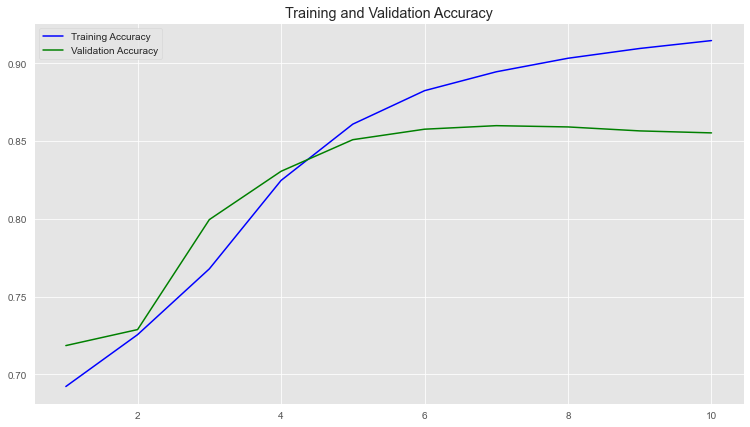

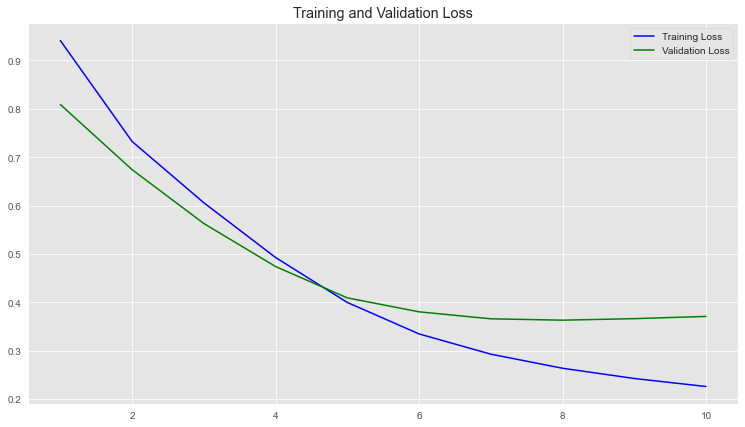

In [601]:
#  plot accuracy and loss


plot_history(history);

#### _Model Evaluations_

In [602]:
# import required packages

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [603]:
# predict the classes for test set

pred_prob = baseline_model().predict(features_test_nn, verbose=0)

# predict crisp classes for test set

pred_class = np.argmax(baseline_model().predict(features_test_nn,verbose=0), axis=-1)
# pred_class = to_categorical(pred_class)

In [604]:
testy = [np.argmax(e,axis=None,out=None) for e in target_test_nn]

In [605]:
# accuracy, precision, recall and f1 score

accuracy = accuracy_score(testy,pred_class)

precision = precision_score(testy,pred_class, average=None)

recall = recall_score(testy,pred_class, average=None)

f1 = f1_score(testy,pred_class, average=None)


f"Accuracy: {accuracy}"
f"Precision:{precision}"
f"Recall: {recall}"
f"F1 Score:{f1}"

'Accuracy: 0.41817685092432383'

'Precision:[0.04787962 0.22484234 0.71328535]'

'Recall: [0.20710059 0.31733746 0.46476553]'

'F1 Score:[0.07777778 0.26320013 0.56281176]'

In [606]:
# confusion matrix

matrix = confusion_matrix(testy,pred_class)
matrix

array([[ 105,  147,  255],
       [ 545,  820, 1219],
       [1543, 2680, 3667]])

In [609]:
# pd.crosstab(testy,pred_class)

In [607]:
# display the classififcation report

print(classification_report(testy,pred_class, target_names=class_mapping.keys()))

                        precision    recall  f1-score   support

science_and_technology       0.05      0.21      0.08       507
                sports       0.22      0.32      0.26      2584
           video_games       0.71      0.46      0.56      7890

              accuracy                           0.42     10981
             macro avg       0.33      0.33      0.30     10981
          weighted avg       0.57      0.42      0.47     10981



# END

## 3. Classifying Images

#### _import required packages_

In [292]:
import tensorflow

tensorflow.__version__

'2.5.0'

In [136]:
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

In [293]:
#  set the color channel value to last for TensorFlow 2.X

K.set_image_data_format("channels_last")

In [294]:
# set seed

np.random.seed(0)

In [295]:
#  set image information

channels = 1
height = 28
width = 28

In [296]:
# load data and target from MNIST data

(data_train, target_train), (data_test, target_test) = mnist.load_data()

In [297]:
data_train.shape

(60000, 28, 28)

In [298]:
# reshape training image data ino features

data_train = data_train.reshape(data_train.shape[0],height, width, channels)

In [299]:
# reshape test image data into features

data_test = data_test.reshape(data_test.shape[0], height, width, channels)

In [300]:
# rescale pixel intensity to between 0, 1

features_train =  data_train/255
features_test = data_test/255

In [301]:
# one-hot encode target

target_train = np_utils.to_categorical(target_train)
target_test = np_utils.to_categorical(target_test)
number_of_classes = target_test.shape[1]

In [304]:
# start neural network

network = Sequential()

In [305]:
# Add convolutional layer with 64 filters, a 5x5 window, and ReLU activation function

network.add(Conv2D(filters=64,kernel_size=(5, 5),input_shape=( width, height,channels),activation='relu'))

In [306]:
# Add max pooling layer with a 2x2 window

network.add(MaxPooling2D(pool_size=(2, 2)))

In [307]:
# Add dropout layer

network.add(Dropout(0.5))

In [308]:
# Add layer to flatten input

network.add(Flatten())

In [309]:
# Add fully connected layer of 128 units with a ReLU activation function

network.add(Dense(128, activation="relu"))

In [310]:
# Add dropout layer

network.add(Dropout(0.5))

In [311]:
# Add fully connected layer with a softmax activation function

network.add(Dense(number_of_classes, activation="softmax"))

In [312]:
# Compile neural network

network.compile(loss="categorical_crossentropy", # Cross-entropy
                   optimizer="rmsprop", # Root Mean Square Propagation
                   metrics=["accuracy"]) # Accuracy performance metric

In [313]:
# Train neural network

network.fit(features_train, # Features
               target_train, # Target
               epochs=2, # Number of epochs
               verbose=1, # Don't print description after each epoch
               batch_size=1000, # Number of observations per batch
               validation_data=(features_test, target_test)) # Data for evaluation

Epoch 1/2
60/60 [==============================] - 28s 443ms/step - loss: 0.9808 - accuracy: 0.6814 - val_loss: 0.1484 - val_accuracy: 0.9586
Epoch 2/2
60/60 [==============================] - 24s 401ms/step - loss: 0.2056 - accuracy: 0.9404 - val_loss: 0.0881 - val_accuracy: 0.9743


In [314]:
# accuracy of the model

score = network.evaluate(features_test,target_test, verbose=0)

f"Test Score: {score[0]}"

f"Test Accuracy: {score[1]}"

'Test Score: 0.08808194100856781'

'Test Accuracy: 0.9743000268936157'

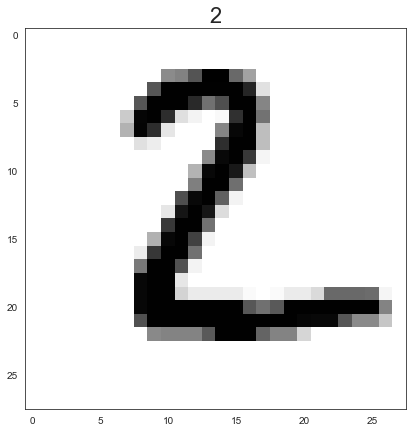

In [334]:
#  evaluation the model by predicting the value

plt.figure(figsize=(7,7))

predictions = network.predict(features_test)
n = 1
plt.imshow(features_test[n].reshape(28, 28), cmap=plt.cm.binary)
plt.title(np.argmax(predictions[n], axis=0), fontdict={'fontsize':22})
plt.show();

# END